# Lesson 3: Neural Networks and Loss Functions



nn.Module, specifying a loss function, MNIST classification.

Intro to CNNs

Inspecting a modern network

Bonus: Working with pretrained models

Bonus: Intro to Dataloaders

### Exercise: Fine-tune a pretrained model on a new classification task

In [ ]:
# Setup and Imports (run this first)
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

# Adding on from last lesson:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16
from tqdm.notebook import tqdm

from tglcourse.data_utils import get_mnist_dl

# Setting device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
html = ipd.display(ipd.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/jzTbQACq7KE" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

/usr/lib/python3/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## A Simple Neural Network
Let's start by making a smallish network to solve a small (contrived) problem. We'll generate some data, and as in the first lesson we'd like our network to learn the relationship between our input data (x) and output data (y).

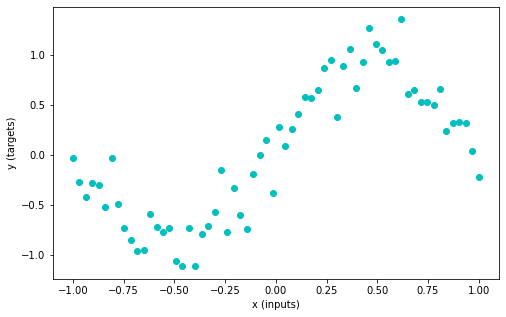

In [ ]:
# Generating some data (inputs and targets)
n_samples = 64
inputs = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 5
targets = torch.sin(3.14 * inputs) + noise
plt.figure(figsize=(8, 5))
plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()

Here's how we can make a neural network, leaning on PyTorch's handy functions:

In [ ]:
## A Wide neural network with a single hidden layer
class WideNet(nn.Module):

  def __init__(self, n_cells=512): # Initialize our network
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, n_cells), # One input, n_cells outputs
        nn.Tanh(), # Our non-linearity - there are many on offer!
        nn.Linear(n_cells, 1), # n_cells inputs, one output
    )

  def forward(self, x):
    return self.layers(x)

We're inheriting from the nn.Module class, which gives us some bonus features. For example, instead of directly calling the forward method (which passes the data through the different layers) we can just create our network and call it like a function:

In [ ]:
wn = WideNet()
print('Input shape:', inputs.shape)
out = wn(inputs) # This passes our data in as the input to the forward method defined above
print('Output shape:', out.shape)
print('PyTorch sumary of wn:')
wn

Input shape: torch.Size([64, 1])
Output shape: torch.Size([64, 1])
PyTorch sumary of wn:


WideNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)

In [ ]:
# TODO show wn.parameters()


Time for our training loop - compare this with the optimization loop we in the previous lesson (spoiler: they're the same!). We're optimizing the parameters of our neural network - all the weights and biases in the different layers.

[<matplotlib.lines.Line2D>]

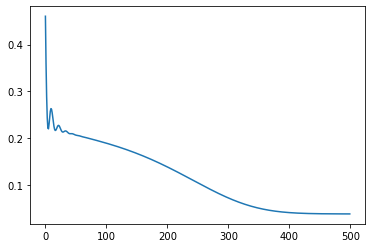

In [ ]:
# Create our network
wide_net = WideNet()

# Create a mse loss function
loss_function = nn.MSELoss()

# Stochstic Gradient Descent optimizer
optimizer = torch.optim.Adam(wide_net.parameters(), lr=1e-3)

# The training loop
losses = []  # keeping recods of loss
for i in range(500): # 500 'epochs' of training
  optimizer.zero_grad()  # set gradients to 0
  predictions = wide_net(inputs)  # Compute model prediction (output)
  loss = loss_function(predictions, targets)  # Compute the loss
  loss.backward()  # Compute gradients (backward pass)
  optimizer.step()  # update parameters (optimizer takes a step)

  # Storing our loss for later viewing
  losses.append(loss.item())

# Plot the losses over time
plt.plot(losses) # Plot the losses over time

**THINK/DISCUSS**: Go line-by-line through the code above - does it make sense?

Notice we don't have to set requires_grad manually on any of the parameters, since the learnable parameters in each layer are grouped automatically by `wide_net.parameters()` (inspect that and see what it contains). 

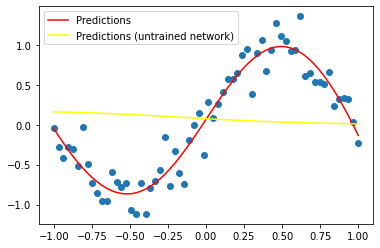

In [ ]:
#@title Plot the predictions vs the actual data
plt.scatter(inputs, targets)
plt.plot(inputs, wide_net(inputs).detach(), c='red', label='Predictions')
# Create a new, untrained widenet and plot those predictions for comparison
new_wn = WideNet()
plt.plot(inputs, new_wn(inputs).detach(), c='yellow', label='Predictions (untrained network)')
plt.legend()
plt.show()

In [ ]:
# Exercise: Create a neural network with two hidden layers and train it on this same task...

## A Lightning Overview of ConvNets
So-called 'dense' networks are useful in some cases, but we need to be mindful of the number of parameters required to solve certain types of problems. For example, consider the case of image recognition - our inputs consist of thousands of individual pixel values. A dense network that could take in 500px images and then run them through many hidden layers ends up with millions or billions of parameters, which can make training tricky.

In addition, each pixel feeds into a different part of the network. When we look at how the vision system works in the brain, or just think about what we'd want in a computer vision system, we'll start to hit requirements that might not be easy to satisfy with a simple MLP network. Fortunately, we have some tricks to imporve things! Here's another video that takes us through a key idea in deep learning for images: CNNs

Here's another video from the (free and I think CC-licenced) neuromatch course that gives a little more background:

In [ ]:
html = ipd.display(ipd.HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/AXO-iflKa58" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
html

/usr/lib/python3/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


The following interactive website is a great way to get an intuition for both how convolution works. You can see each learned filter and the corresponding output. It also shows a second key idea: pooling. By 'downsampling' the outputs of successinve convolution layers we end up with fewer and fewer activations, each representing more and more of the input image. Play around a bit until you're sort of happy with the basic concepts (see the video for more discussion and explanations) and then move on to the next section, where we'll build our own very similar network.

In [ ]:
# html = ipd.display(ipd.HTML('<iframe width="1200" height="600" src="https://adamharley.com/nn_vis/cnn/3d.html" title="CNN Visualization" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'))
# html

For more on what convolution is, how the different hyperparameters (padding, stride etc) do and a general overview of CNNs, see https://poloclub.github.io/cnn-explainer/

## The Dataset
We'll use the classic MNIST dataset (as shown in the video and examples above). But these same ideas apply to more complex image recognition

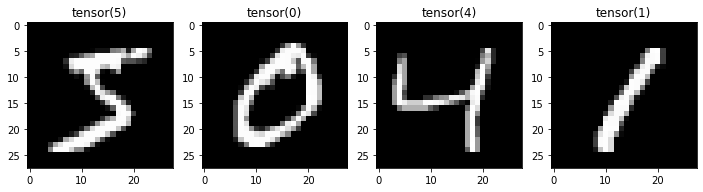

In [ ]:
#@title Loading the data
mnist_dl_train = get_mnist_dl(batch_size=4, split='train')
mnist_dl_test = get_mnist_dl(batch_size=4, split='test')

# Get one batch of data
images, labels = next(iter(mnist_dl_train)).values()

data_shape = (1, 28, 28)

# Plot a few examples
fig, axs = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
  im, label = images[i], labels[i]
  axs[i].imshow(im.squeeze(), cmap='gray')
  axs[i].set_title(label)

## Defining Our Network
The convolution operation is handled by the nn.Conv2d layer. Uncomment the next line to view some info about this:

In [ ]:
# ?nn.Conv2d

Let's use nn.Conv2D to convolve this image with some random kernels:

In [ ]:
conv_test = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5,
                           padding=0)
image = images[0].unsqueeze(0) # unsqueeze to make this a 'batch of size 1'
print('Input shape: ', image.shape) # One channel greyscale image
print('Output shape: ', conv_test(image).shape) # 12 output channels (from 12 kernels)

Input shape:  torch.Size([1, 1, 28, 28])
Output shape:  torch.Size([1, 12, 24, 24])


Note the initial shape is slightly smaller - how does padding change this? Does the output shape make sense?

This layer has some trainable parameters: the kernels. Let's check these out:

In [ ]:
conv_test.weight.shape # 12 filters, each 1x5x5 

torch.Size([12, 1, 5, 5])

Here's a network that uses these layers (along with nn.MaxPool2d for the downsampling/pooling). We could use nn.Sequential as in the previous example, but I'd like to show another common style here. We define all the layers we'll need in __init__ but only in the forward() method do we actually specify how that data should flow through the network.

In [ ]:
# Network definition
class MiniCNN(nn.Module):
  def __init__(self):
    super(MiniCNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10) # 10 outputs (for 10 digits)
    self.pool = nn.MaxPool2d(2)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    return x

## The Training Loop

![training](https://media3.giphy.com/media/xT0xekSmUwcoD6SxzO/giphy.gif)

Here's a training loop that should now be getting quite familiar. A few noteworthy things:
- We can't push all the images through in one go, so within each epoch (i.e. each full psas through the data) we do multiple batches. This is when 'Gradient Descent' becomes 'Stochastic Gradient Descent' or 'Mini-batch GD' depending on who you're talking to. PyTorch does the batching for us via something called a `DataLoader`. 
- We'd like to train on the GPU, so we need to make sure both the model and the data are on the right device with `.to(device)` (device is defined earlier).
- We're using a loss function that is good for classification tasks: `nn.CrossEntropyLoss()`. Accuracy has 'steps' and so it makes differentiation tricky. By treating the outputs of the network as probabilities we can see how confident it is that something is in a specific class while keeping everything continuous and differentiable. Don't worry too much about this :)

In [ ]:
#|eval: false

# Set up model, loss and optimizer
model = MiniCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01)

# The training loop
for epoch in range(2):
  print(f'Epoch {epoch}')
  for batch in tqdm(mnist_dl_train, unit='batch'):
    data, target = batch['image'], batch['label']
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    
# Breaks to avoid long loop in CI TODO figure this out
  #   break
  # break

Epoch 0


0batch [00:00, ?batch/s]

KeyboardInterrupt: 

ASIDE: remove all to(device) in the above code - is it slower on CPU?

## Evaluation - how well does it do?

![testing](https://media3.giphy.com/media/JRPftUYuIRw3axuh5y/giphy-downsized-large.gif)

In [ ]:
#|eval: false

## Testing
correct = 0
total = 0

with torch.no_grad():
  # Iterate through test set minibatchs
  for batch in tqdm(mnist_dl_test):
    data, labels = batch.values() # TODO fix this in data eg
    data, labels = data.to(device), labels.to(device) # Move the data to GPU for faster execution.
    y = model(data) # Forward pass
    predictions = torch.argmax(y, dim=1) # The model has ten outputs, one for each digit. Here we take the index with the highest output
    correct += torch.sum((predictions == labels).float())
    total += labels.shape[0]

print(f'Test accuracy: {correct/total * 100:.2f}%')

0it [00:00, ?it/s]

Test accuracy: 96.04%


In [ ]:
#Exercise: See how good you can get! Tweak the architecture, the hyperparameters, the training time, the optimizer... go wild ;)

Phew! Welcome to deep learning :) 

We're learning just enough to move on with the course, but these are some big topics and we're barely scratching the surface. If you're interested in more of the theory or implementing some of these ideas from scratch, you might like to check out the content at https://deeplearning.neuromatch.io/ or one of the many deep learning courses on various MOOC platforms. If you'd like a more top-down approach to doing practical deep learning realy well, I can't recommend the [fastai course](https://course.fast.ai) highly enough. 

There is also a great from-scratch lesson from Andrej Karpathy going into all the nitty-gritty details of how gradients are calculated and so on: https://www.youtube.com/watch?v=VMj-3S1tku0 TODO embed and explain more.


In [ ]:
# TODO project/example with this...

In [ ]:
# TODO try widenet on mnist as well

In [ ]:
# TODO also need to explore different optimizers and regularization somewhere

In [ ]:
# TODO export widenet and MiniCNN for later use